<a href="https://colab.research.google.com/github/bye23mj/suanLee/blob/main/TF_3_1_%EC%BC%80%EB%9D%BC%EC%8A%A4_%EB%B3%B4%EC%8A%A4%ED%84%B4_%EC%A3%BC%ED%83%9D_%EA%B0%80%EA%B2%A9_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 케라스 보스턴 주택 가격 모델

### modules import

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets.boston_housing import load_data
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

### 데이터 로드
- 데이터의 수가 상당히 적기 때문에 테스트 데이터의 비율을 20%로 지정

- 13개의 특성을 가짐

- 각각의 특성이 모두 다른 스케일, 즉 단위가 모두 다름
  - 범죄율: 0~1 사이의 값
  - 방의 개수 3~9 사이의 값

- 정답 레이블은 주택 가격의 중간가격($1000 단위)

In [ ]:
tf.random.set_seed(111)

(x_train_full, y_train_full), (x_test, y_test) = load_data(path='boston_housing.npz', 
                                                           test_split=0.2, 
                                                           seed=111)

### 데이터 확인

In [ ]:
print(x_train_full.shape, y_train_full.shape)
print(x_test.shape, y_test.shape)

(404, 13) (404,)
(102, 13) (102,)


In [ ]:
print(x_train_full[0])

[2.8750e-02 2.8000e+01 1.5040e+01 0.0000e+00 4.6400e-01 6.2110e+00
 2.8900e+01 3.6659e+00 4.0000e+00 2.7000e+02 1.8200e+01 3.9633e+02
 6.2100e+00]


In [ ]:
print(y_train_full[0])

25.0


### 데이터 전처리
- Standardization

- 특성의 단위가 모두 다르기 때문에 **동일한 범위로 조정**

In [ ]:
mean = np.mean(x_train_full, axis=0)
std = np.std(x_train_full, axis=0)

x_train_preprocessed = (x_train_full - mean) / std
x_test = (x_test - mean) / std

x_train, x_val, y_train, y_val = train_test_split(x_train_preprocessed, y_train_full, test_size=0.3, random_state=111)

In [ ]:
print(x_train_full.shape, y_train_full.shape)
print(x_test.shape, y_test.shape)

(404, 13) (404,)
(102, 13) (102,)


### 모델 구성
- 학습 데이터가 매우 적은 경우에 모델의 깊이를 깊게 할수록  
  과대적합(Overfitting)이 일어날 확률이 높음

In [ ]:
model = Sequential([Dense(100, activation='relu', input_shape=(13,), name='dense1'),
                   Dense(64, activation='relu', name='dense2'),
                   Dense(32, activation='relu', name='dense3'),
                   Dense(1, name='output')
                   ])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense1 (Dense)              (None, 100)               1400      
                                                                 
 dense2 (Dense)              (None, 64)                6464      
                                                                 
 dense3 (Dense)              (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 9,977
Trainable params: 9,977
Non-trainable params: 0
_________________________________________________________________


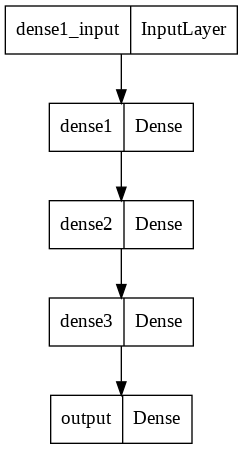

In [ ]:
plot_model(model)

### 모델 컴파일(compile)

- 회귀 문제에서는 주로 평균제곱오차(MSE, Mean Squared Error)를 손실함수로,  
  평균절대오차(MAE, Mean Absolute Error)를 평가지표로 많이 사용!

In [ ]:
model.compile(loss='mse',
              optimizer=Adam(learning_rate=1e-2),
              metrics=['mae'])

### 모델 학습

In [ ]:
history = model.fit(x_train, y_train, epochs=300, validation_data=(x_val, y_val))

### 모델 평가 
- `evaluate()`

In [ ]:
model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 3ms/step - loss: 13.9617 - mae: 2.6247


[13.961652755737305, 2.624713659286499]

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


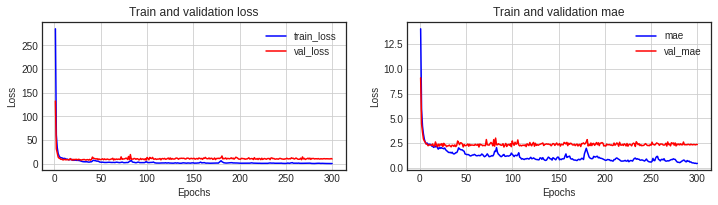

In [ ]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(2,2,1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title('Train and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

mae = history_dict['mae']
val_mae = history_dict['val_mae']

ax1 = fig.add_subplot(2,2,2)
ax1.plot(epochs, mae, color='blue', label='mae')
ax1.plot(epochs, val_mae, color='red', label='val_mae')
ax1.set_title('Train and validation mae')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()



### K-Fold 교차 검증

- 데이터셋의 크기가 매우 작은 경우에  
  [훈련, 검증, 테스트] 데이터로 나누게 되면 과소적합이 일어날 확률이 높음

- 이를 해결하기 위해 K-Fold 교차 검증 실행
  <br>

  <img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="600">

  <sub>출처: https://scikit-learn.org/stable/modules/cross_validation.html</sub>

### 모델 재구성

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
tf.random.set_seed(111)

(x_train_full, y_train_full), (x_test, y_test) = load_data(path='boston_housing.npz', 
                                                           test_split=0.2, 
                                                           seed=111)

In [ ]:
mean = np.mean(x_train_full, axis=0)
std = np.std(x_train_full, axis=0)

x_train_preprocessed = (x_train_full - mean) / std
x_test = (x_test - mean) / std

In [ ]:
k = 3

kfold = KFold(n_splits=k)

In [ ]:
def build_model():
  input = Input(shape=(13,), name='input')
  hidden1 = Dense(100, activation='relu', name='dense1')(input)
  hidden2 = Dense(64, activation='relu', name='dense2')(hidden1)
  hidden3 = Dense(32, activation='relu', name='dense3')(hidden2)
  output = Dense(1, name='output')(hidden3)

  model = Model(inputs=[input], outputs=output)

  model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae'])
  
  return model

In [ ]:
mae_list = []

In [ ]:
for train_idx, val_idx in kfold.split(x_train):
  x_train_fold, x_val_fold = x_train[train_idx], x_train[val_idx]
  y_train_fold, y_val_fold = y_train_full[train_idx], y_train_full[val_idx]

  model = build_model()

  model.fit(x_train_fold, y_train_fold, epochs=300,
            validation_data=(x_val_fold, y_val_fold))
  
  _, test_mae = model.evaluate(x_test, y_test)
  mae_list.append(test_mae)

Epoch 1/300
6/6 [==============================] - 2s 94ms/step - loss: 599.4890 - mae: 22.6237 - val_loss: 624.0937 - val_mae: 23.0058
Epoch 2/300
6/6 [==============================] - 0s 33ms/step - loss: 568.0335 - mae: 21.9072 - val_loss: 593.2933 - val_mae: 22.3224
Epoch 3/300
6/6 [==============================] - 0s 19ms/step - loss: 534.9873 - mae: 21.1191 - val_loss: 556.8061 - val_mae: 21.4813
Epoch 4/300
6/6 [==============================] - 0s 7ms/step - loss: 494.4675 - mae: 20.1320 - val_loss: 511.0756 - val_mae: 20.3743
Epoch 5/300
6/6 [==============================] - 0s 11ms/step - loss: 445.2064 - mae: 18.8349 - val_loss: 452.4166 - val_mae: 18.8394
Epoch 6/300
6/6 [==============================] - 0s 11ms/step - loss: 382.9087 - mae: 17.1091 - val_loss: 380.2213 - val_mae: 16.7634
Epoch 7/300
6/6 [==============================] - 0s 8ms/step - loss: 310.7935 - mae: 14.8474 - val_loss: 298.6646 - val_mae: 14.1138
Epoch 8/300
6/6 [==============================] -

In [ ]:
print(mae_list)

[8.992217063903809, 8.051098823547363, 9.680806159973145]


In [ ]:
print(np.mean(mae_list))

8.908040682474772
